In [2]:
import os
import resource
import psutil

# Set memory limit
memory_limit = 16 * 1024 * 1024 * 1024  # 16GB in bytes
resource.setrlimit(resource.RLIMIT_AS, (memory_limit, memory_limit))

# Restrict CPU core usage
p = psutil.Process()
p.cpu_affinity([0]) 

In [2]:
import tensorflow as tf
import psutil
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import time
import matplotlib.pyplot as plt

# Disable GPU usage
tf.config.set_visible_devices([], 'GPU')
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices=false'

# Available devices
print("Available devices:", tf.config.list_physical_devices())

# CPU Count
print("CPU Count:", os.cpu_count())

2025-03-13 03:44:55.774490: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-13 03:44:55.774565: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-13 03:44:55.776039: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-13 03:44:55.787683: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Available devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
CPU Count: 40


In [3]:
model_name = "gpt2" 
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)

In [4]:
#Set Pad Token and Model to Evaluation Mode
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token  # Set EOS token as the pad_token

model.eval() 

# Prompt
prompt = "What is the capital of Denmark?"

# Encode + tokenize + padding
inputs = tokenizer(prompt, return_tensors="pt", padding=True)  # Ensure padding is applied if needed

# Attention mask
attention_mask = inputs['attention_mask']

Average Latency: 2192.55 ms


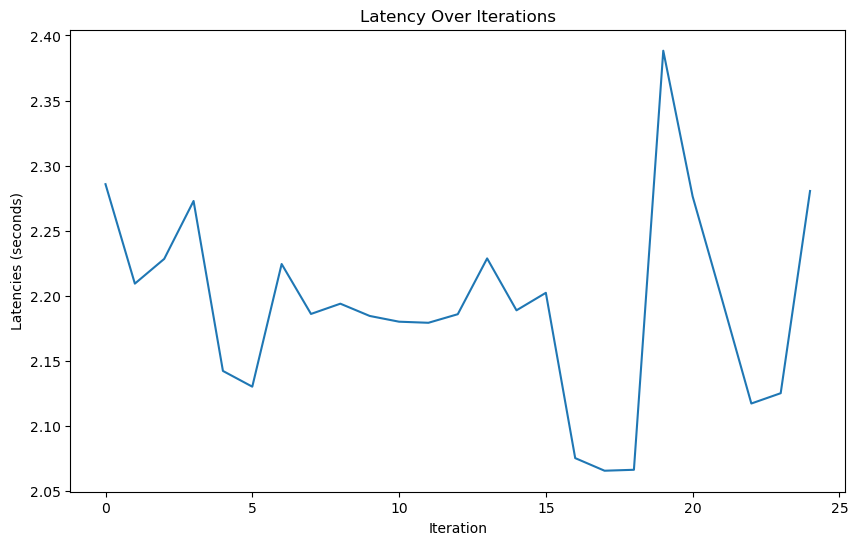

In [5]:
# Measure Latency Over Multiple Iterations
def measure_latency(tokenizer, model, prompt, iterations=25):
    latencies = []
    inputs = tokenizer(prompt, return_tensors="pt", padding=True)  # Encode the prompt with padding
    attention_mask = inputs['attention_mask']  # Get the attention mask
    
    # Set pad_token_id to eos_token_id if necessary
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    
    for _ in range(iterations):
        start_time = time.time()
        model.generate(
            inputs['input_ids'], 
            attention_mask=attention_mask,  # Pass the attention mask
            max_length=50,
            pad_token_id=tokenizer.pad_token_id  # Set pad token explicitly
        )
        end_time = time.time()
        latencies.append (end_time - start_time)
    average_latency = sum(latencies) / len(latencies)
    return average_latency, latencies

average_latency, latencies = measure_latency(tokenizer, model, prompt)
print(f"Average Latency: {average_latency * 1000:.2f} ms")

plt.figure(figsize=(10, 6))
plt.plot(latencies)
plt.title('Latency Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Latencies (seconds)')
plt.show()

Average Throughput: 1.56 samples/second


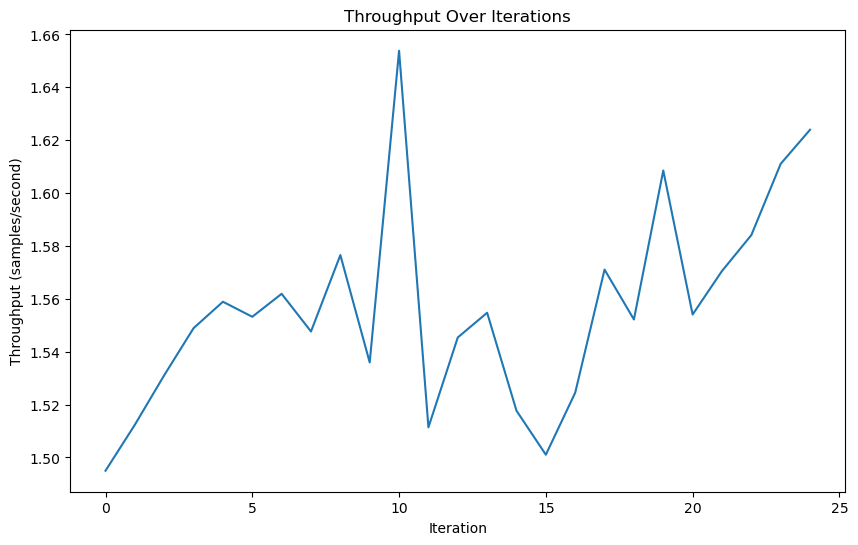

In [6]:
# Measure Throughput Over Multiple Iterations
def measure_throughput(tokenizer, model, prompt, batch_size=8, iterations=25):
    throughputs = []
    inputs = tokenizer([prompt] * batch_size, return_tensors="pt", padding=True, truncation=True, return_attention_mask=True)
    attention_mask = inputs['attention_mask']
    
    # Set pad_token_id to eos_token_id if necessary
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    
    for _ in range(iterations):
        start_time = time.time()
        model.generate(
            inputs['input_ids'], 
            attention_mask=attention_mask,  # Pass the attention mask
            max_length=50,
            pad_token_id=tokenizer.pad_token_id  # Set pad token explicitly
        )
        end_time = time.time()
        throughput = batch_size / (end_time - start_time)
        throughputs.append(throughput)
    
    average_throughput = sum(throughputs) / len(throughputs)
    return throughputs, average_throughput

prompt = "Mary had a little lamb"
throughputs, average_throughput = measure_throughput(tokenizer, model, prompt)
print(f"Average Throughput: {average_throughput:.2f} samples/second")

plt.figure(figsize=(10, 6))
plt.plot(throughputs)
plt.title('Throughput Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Throughput (samples/second)')
plt.show()